# forward simulation and inversion for a linear problem 

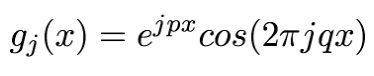

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) *
        np.cos(2 * np.pi * j * q * x)
    )

## build a mesh

In [3]:
n_cells = 100 
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes)

In [4]:
n_kernels = 5

p = -0.05
q = 0.1

j0 = 1
jN = 30 

j_values = np.linspace(j0, jN, n_kernels) 

In [5]:
G_nodes = np.zeros((n_nodes, n_kernels))

for j, jk in enumerate(j_values):
    G_nodes[:, j] = kernel_function(x_nodes, jk, p, q)

In [6]:
def get_G_nodes(x_nodes, n_kernels, j0=1, jN=30, p=-0.05, q=0.1): 
    j_values = np.linspace(j0, jN, n_kernels)
    n_nodes = len(x_nodes) 
    G_nodes = np.zeros((n_nodes, n_kernels))

    for j, jk in enumerate(j_values):
        G_nodes[:, j] = kernel_function(x_nodes, jk, p, q)

    return G_nodes

In [7]:
G2 = get_G_nodes(x_nodes, n_kernels=5) 

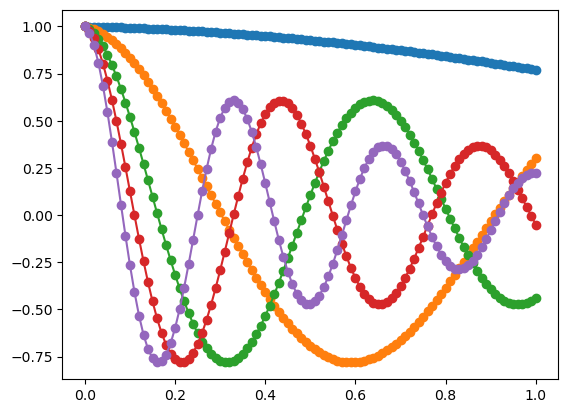

In [8]:
for i in range(n_kernels):
    plt.plot(x_nodes, G_nodes[:, i], color=f"C{i}")
    plt.plot(x_nodes, G2[:, i], "o", color=f"C{i}") 

## Build our model

In [9]:
# need to define x_centers 
x_centers  = 0.5*(x_nodes[:-1] + x_nodes[1:])

In [10]:
delta_x = np.diff(x_nodes)
x_centers2 = delta_x / 2 + x_nodes[:-1]

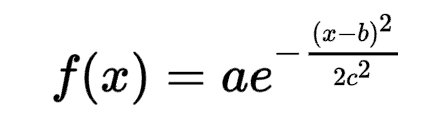

In [11]:
def get_model(
    x_centers,
    x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar=0.5,
    std_gaussian=0.05, amplitude_gaussian=1, center_gaussian = 0.7
): 
    """
    Function to get a model with a boxcar and a gaussian
    """
    model = np.zeros(n_cells)
    
    # define a boxcar
    inds_boxcar = (x_centers >= x_boxcar_min) & (x_centers <= x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar
    
    # define a gaussian
    gaussian = amplitude_gaussian * np.exp(-(x_centers-center_gaussian)**2 / (2*std_gaussian**2))
    model = model + gaussian

    return model


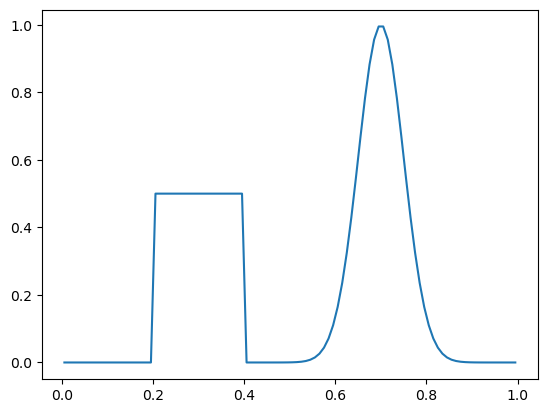

In [12]:
model = get_model(x_centers)
plt.plot(x_centers, model)

In [13]:
# the dense approach to building this matrix
# n_nodes_tmp = 5
# n_cells_tmp = n_nodes_tmp - 1

# Av = np.zeros((n_cells_tmp, n_nodes_tmp))

# for i in range(n_cells_tmp):
#     Av[i, i] = 0.5
#     Av[i, i+1] = 0.5

In [14]:
# array of nnodes filled with 0.5 
# av_entries = np.vstack(
#     [0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)]
# )
# Av = sp.spdiags(av_entries, [0, 1] , m=n_cells, n=n_nodes) 

In [15]:
# plt.spy(Av)
# plt.matshow(Av2.todense())

In [16]:
# diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)

In [17]:
# G = (Av @ G_nodes).T @ diag_delta_x

In [18]:
# G.shape

In [19]:
def get_G(x_nodes, n_kernels, j0=1, jN=30, p=-0.05, q=0.1): 
    G_nodes = get_G_nodes(x_nodes, n_kernels=n_kernels, j0=j0, jN=jN, p=p, q=q)

    # Averaging matrix 
    av_entries = np.vstack(
        [0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)]
    )
    Av = sp.spdiags(av_entries, [0, 1] , m=n_cells, n=n_nodes) 

    delta_x = np.diff(x_nodes)
    diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)

    G = (Av @ G_nodes).T @ diag_delta_x

    return G

In [20]:
n_kernels = 30
G = get_G(x_nodes, n_kernels)
data = G @ model

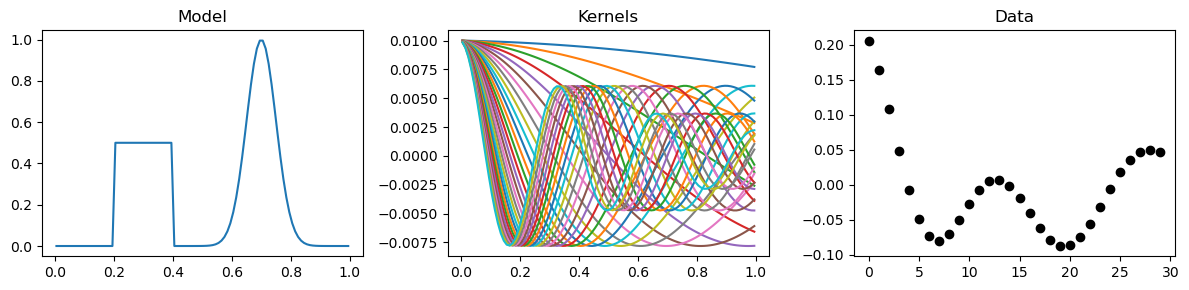

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(x_centers, model)
ax[0].set_title("Model")

ax[1].plot(x_centers, G.T)
ax[1].set_title("Kernels")

ax[2].plot(data, "o", color="k")
ax[2].set_title("Data")

plt.tight_layout()

In [22]:
n_kernels

30

In [23]:
G.shape

(30, 100)

In [26]:
Wd = sp.eye(n_kernels) 

In [51]:
A = (G.T @ Wd.T @ Wd @ G) #+ sp.eye(n_cells)
A.shape

(100, 100)

In [52]:
b = G.T @ Wd.T @ Wd @ data
b.shape

(100,)

In [53]:
m_recovered = np.linalg.solve(A, b)

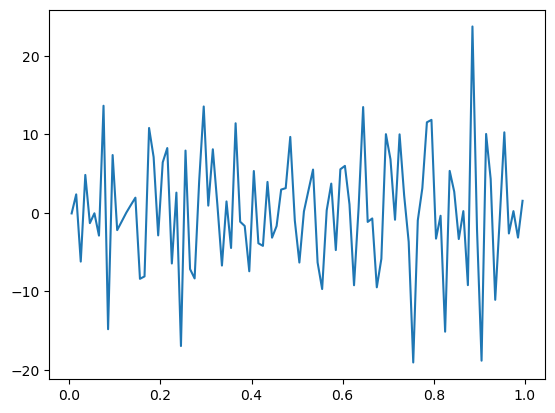

In [54]:
plt.plot(x_centers, m_recovered)

In [33]:
eigenvalues, eigenvectors = np.linalg.eig(A)

In [34]:
eigenvalues.shape

(100,)

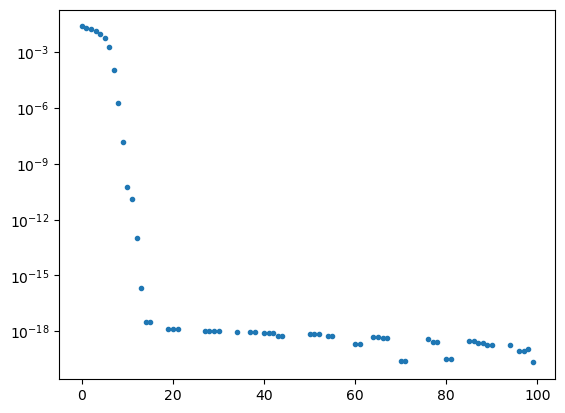

In [36]:
plt.semilogy(eigenvalues, ".")

# Add regularization

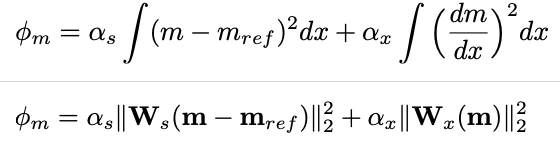

In [66]:
# smallness term 
Ws = sp.diags(np.sqrt(delta_x), 0, shape=(n_cells, n_cells))
Ws.todense()[:6, :6]

matrix([[0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.1, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.1, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.1]])

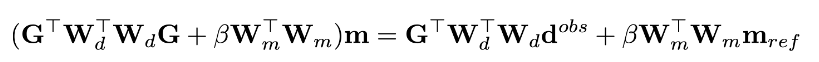

In [75]:
beta = 1e-1
H = (G.T @ Wd.T @ Wd @ G) + beta * Ws.T @ Ws
H.shape

(100, 100)

In [76]:
rhs = G.T @ Wd.T @ Wd @ data
rhs.shape

(100,)

In [77]:
m_recovered = np.linalg.solve(H, rhs)

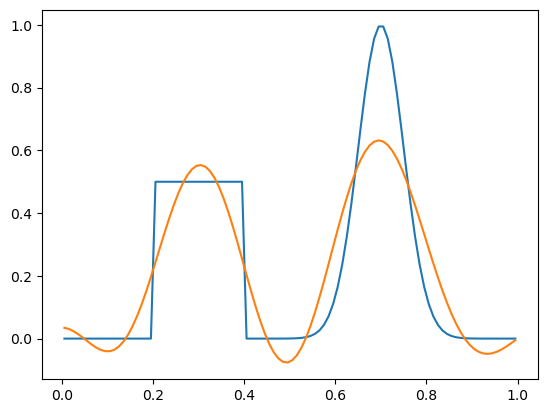

In [78]:
plt.plot(x_centers, model)
plt.plot(x_centers, m_recovered)